## A 250-hPa Hemispheric Ageostrophic Geopotential Flux
By: Kevin Goebbert

Date: 24 June 2015

Modified: 27 October 2016, 5 April 2017, 21 December 2019



In [1]:
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib
matplotlib.use('TkAgg') # do this before importing pylab
import matplotlib.pyplot as plt
from metpy.units import units
import metpy.calc as mpcalc
import metpy.constants
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr

In [11]:
date = datetime(2019, 3, 13, 0)

# ds = xr.open_dataset('http://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g3-anl-files-old/'
#                      f'{date:%Y%m}/{date:%Y%m%d}/gfsanl_3_{date:%Y%m%d}_{date:%H}00_000.grb2')

#ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg_ana/TP')

ds = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/aggregations/g/ds083.2/2/TP')

#ds = ds.metpy.sel(time=slice(date, date+timedelta(hours=12)))
ds = ds.metpy.sel(time=date)

# reftime = ds.Geopotential_height_isobaric.reftime.values.astype('datetime64[ms]').astype('O')
# try:
#     if len(reftime) > 1:
#         reftime = reftime[0]
# except:
#     pass
reftime = 0

lat = ds.lat.sel(lat=slice(90, 0)).values
lon = cutil.add_cyclic_point(ds.lon.values)
vtimes = ds.Geopotential_height_isobaric.metpy.time.values.astype('datetime64[ms]').astype('O')

# Choose whether you want just the analysis or all forecast hours
#ntimes = vtimes.size
ntimes = 1

cint = 120
clev250 = np.arange(9000, 12000, cint)

crs = ccrs.NorthPolarStereo(central_longitude=-100.0)

# Make a grid of lat/lon values to use for plotting with Cartopy.
lons, lats = np.meshgrid(lon, lat)

tlatlons = crs.transform_points(ccrs.PlateCarree(),lons,lats)
clons = tlatlons[:,:,0]
clats = tlatlons[:,:,1]

gravity = metpy.constants.g
f = mpcalc.coriolis_parameter(lats * units.degrees).to(units('1 / sec'))

dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

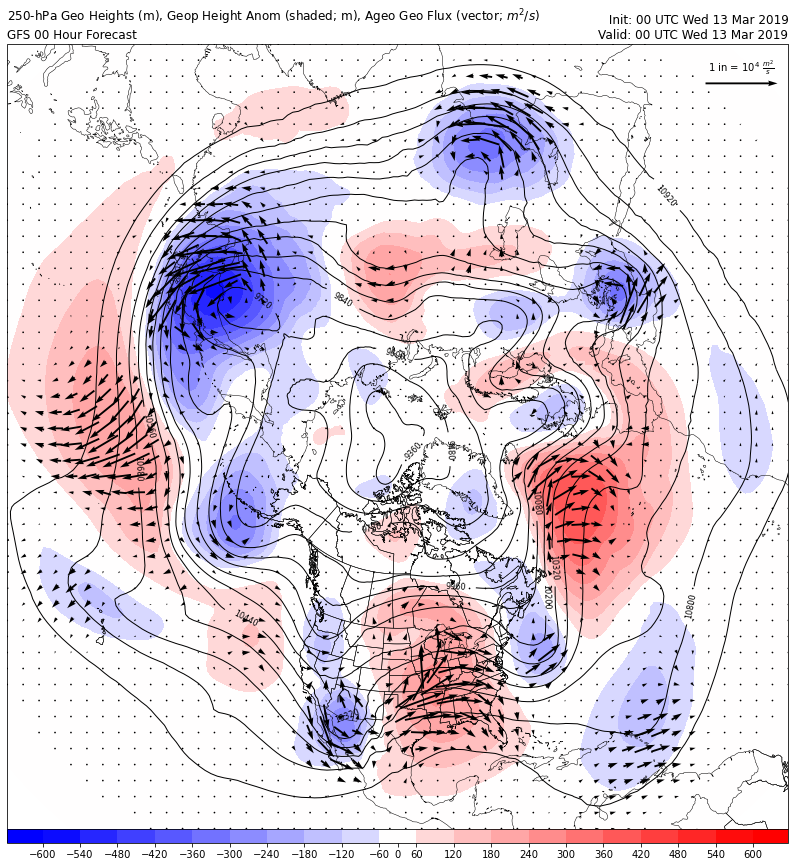

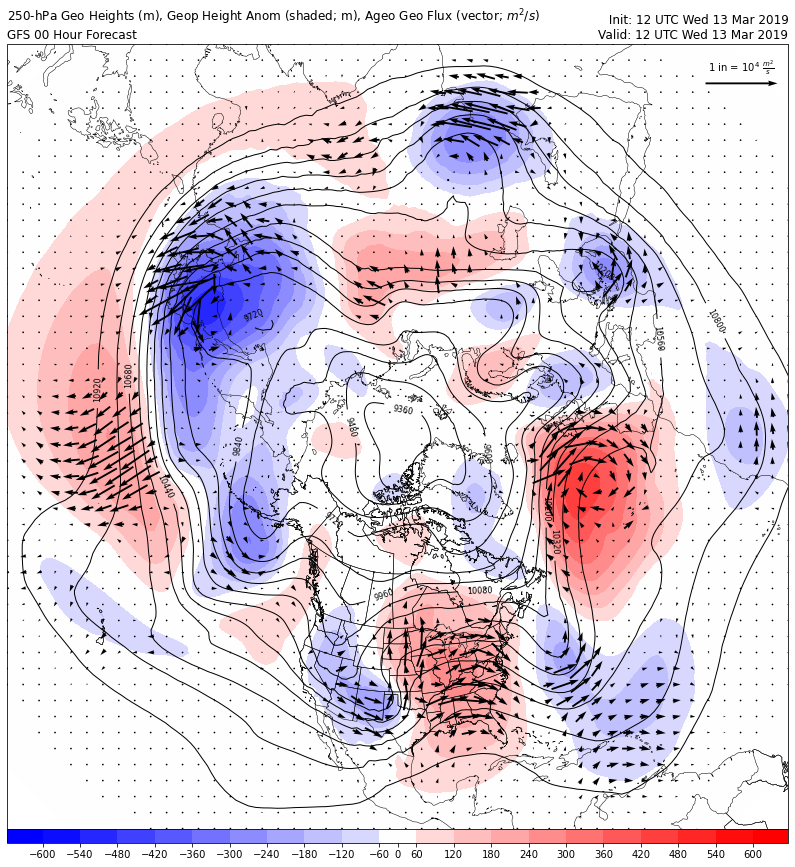

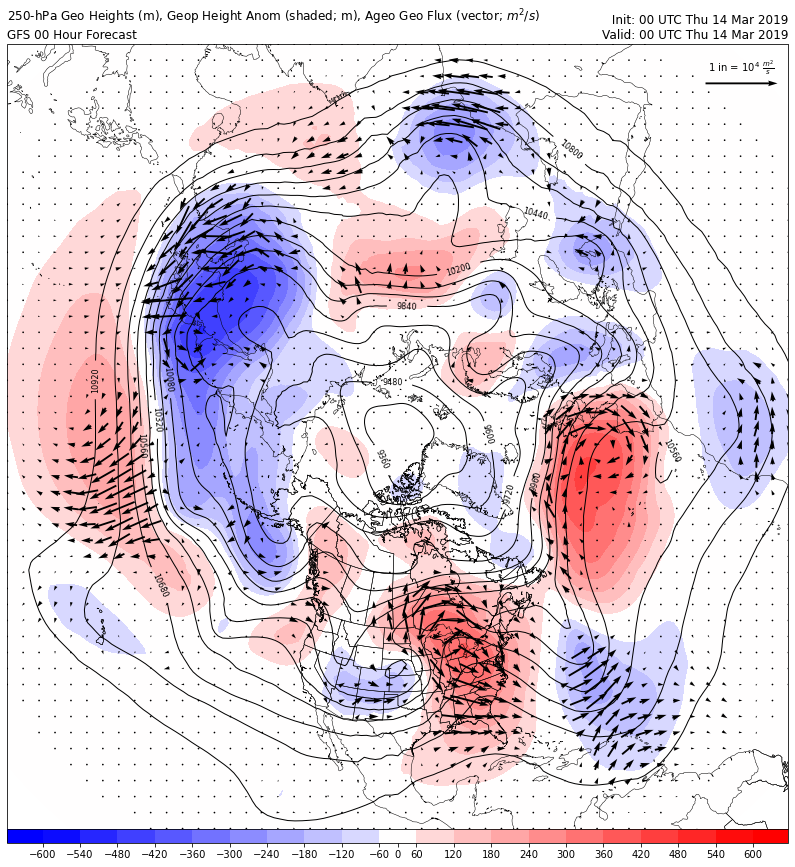

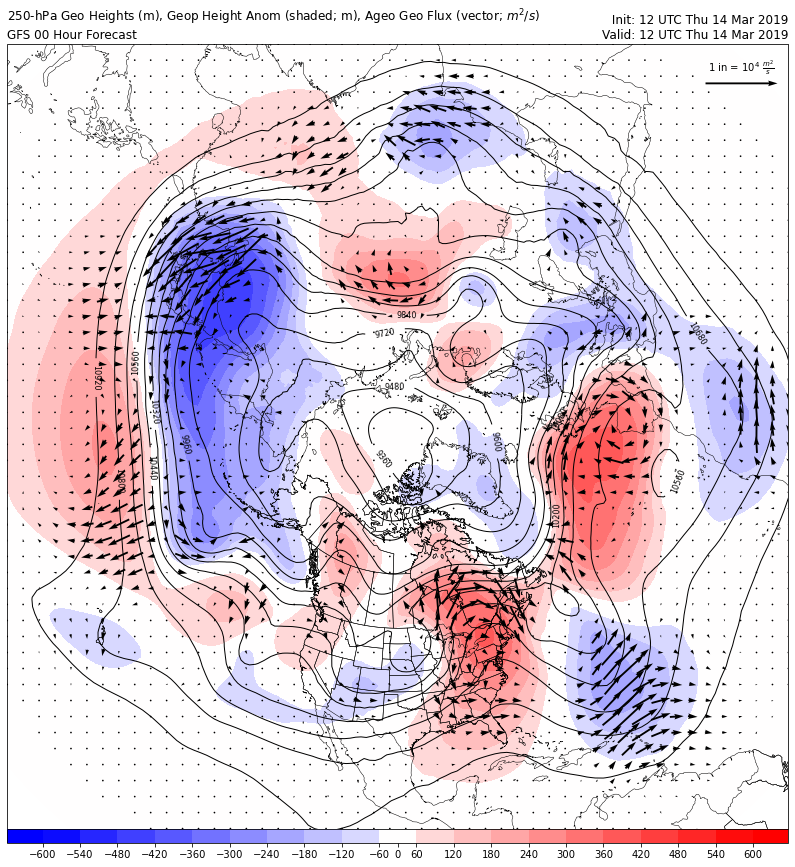

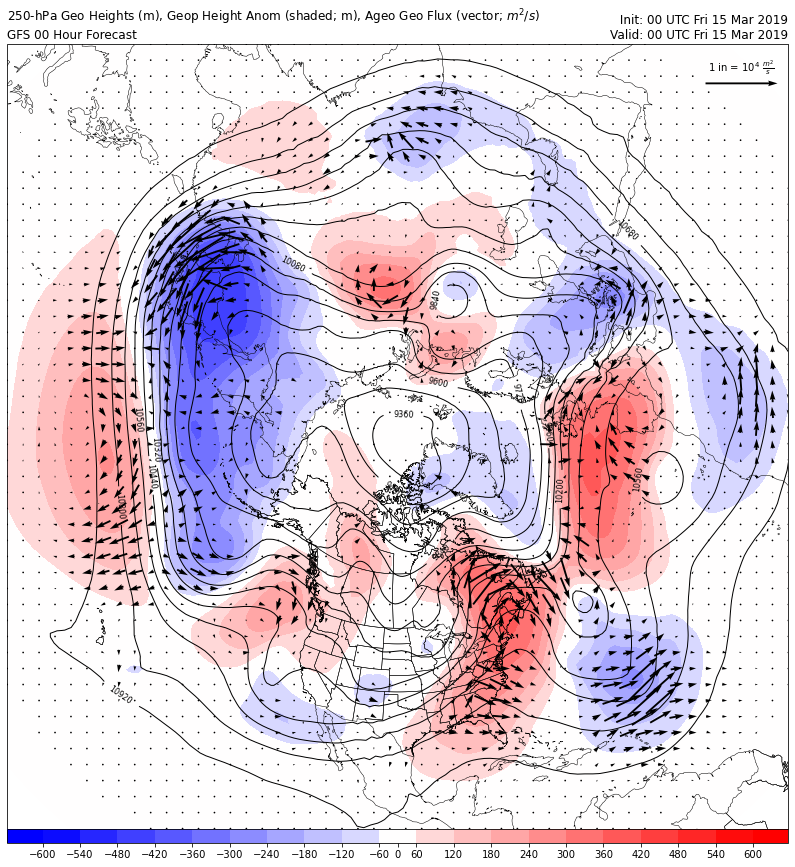

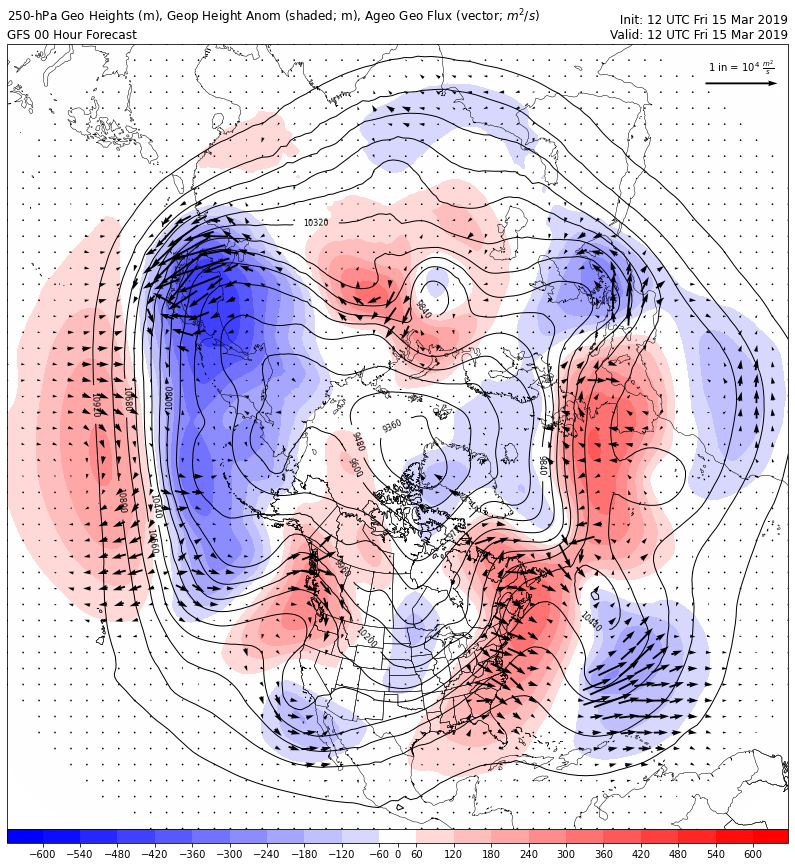

In [21]:
%matplotlib inline

for val in range(6):
    date = datetime(2019, 3, 13) + timedelta(hours=val*12)
    subset = dict(time=date, vertical=250*units.hPa, lat=slice(90, 0))
    hght = ds.Geopotential_height_isobaric.metpy.sel(subset).metpy.unit_array
    uwnd = ds['u-component_of_wind_isobaric'].metpy.sel(subset).metpy.unit_array
    vwnd = ds['v-component_of_wind_isobaric'].metpy.sel(subset).metpy.unit_array
    hgt_250 = cutil.add_cyclic_point(hght)
    u250 = cutil.add_cyclic_point(uwnd)
    v250 = cutil.add_cyclic_point(vwnd)

    mean_hght_lat = np.average(hgt_250, axis=1)[:,None]
    anom_hght_lat = hgt_250 - mean_hght_lat
    
    Z_250 = mpcalc.smooth_gaussian(hgt_250, 1.5)
    ug250, vg250 = mpcalc.geostrophic_wind(Z_250, dx, dy, latitude=lats*units.degrees)
    
    fig=plt.figure(HOUR, figsize=(14.,17.))
    ax = plt.subplot(111, projection=crs)
    #   ax.set_extent([west long, east long, south lat, north lat])
    ax.set_extent([-180, 180, 15, 90], ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
    cs = ax.contour(clons, clats, Z_250, clev250, colors='k', linewidths=1.0, linestyles='solid')

    cint = np.arange(-600, 601, 60)
    cf = ax.contourf(clons, clats, anom_hght_lat, cint[(cint != 0)], cmap=plt.cm.bwr, extend='both')
    plt.clabel(cs, fontsize=8, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

    # Transform Vectors before plotting, then plot wind barbs.
    u250t, v250t = crs.transform_vectors(ccrs.PlateCarree(), lons, lats, u250, v250)
    ug250t, vg250t = crs.transform_vectors(ccrs.PlateCarree(), lons, lats, ug250.m, vg250.m)

    ugeo250flux = (u250t - ug250t) * anom_hght_lat
    vgeo250flux = (v250t - vg250t) * anom_hght_lat
    
    skip = 5
    wind_slice = [slice(None, None, skip), slice(None, None, skip)]
    q = ax.quiver(clons[wind_slice], clats[wind_slice],
                  ugeo250flux[wind_slice], vgeo250flux[wind_slice], regrid_shape=50,
                  pivot='mid', angles='uv', scale=10000, scale_units='inches')
    ax.quiverkey(q, .94, .95, 10000, r'1 in = $10^4$ $\frac{m^2}{s}$')
    
    cmap = plt.cm.get_cmap("BuPu")
    plt.colorbar(cf,orientation='horizontal',extend='max',extendrect='True',ticks=cint,pad=0,aspect=50)
    
    #FH = (vtimes[HOUR] - reftime).total_seconds()/3600
    FH = 0
    ax.set_title(r'250-hPa Geo Heights (m), Geop Height Anom (shaded; m), '
                 'Ageo Geo Flux (vector; $m^2/s$)\n'
                 f'GFS {FH:02.0f} Hour Forecast',loc='left')
    ax.set_title(f' Init: {date:%H UTC %a %d %b %Y}\n'
                 f'Valid: {date:%H UTC %a %d %b %Y}', loc='right')
    
    plt.savefig(f'ageoflux_{date:%Y%m%d_%H%M}.png', bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()